***本项目是用来演示使用中文菜谱数据调优ChatGLM2-6B***

### 1、加载模型

In [1]:

from transformers import  AutoModel,AutoTokenizer, BitsAndBytesConfig
import torch
model_name = "./models/chatglm2-6b" #  #或者远程 “THUDM/chatglm2-6b”
# .cache/huggingface/hub/models--THUDM--chatglm2-6b/snapshots/4e38bef4c028beafc8fb1837462f74c02e68fcc2/

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True, #QLoRA 设计的 Double Quantization
    bnb_4bit_quant_type='nf4', # QLoRA 设计的 Normal Float 4 量化数据类型
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name,
                                  quantization_config=bnb_config,
                                  trust_remote_code=True) #.half().cuda()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
# 使用 Markdown 格式打印模型输出
from IPython.display import display, Markdown, clear_output

def display_answer(query, history=[]):
    for response, history in model.stream_chat(
            tokenizer, query, history=history):
        clear_output(wait=True)
        display(Markdown(response))
    return history

In [7]:
# 测试当前模型的能力
history = display_answer("你叫什么")

我是一个名为 ChatGLM2-6B 的人工智能助手，是基于清华大学 KEG 实验室和智谱 AI 公司于 2023 年共同训练的语言模型开发的。我的任务是针对用户的问题和要求提供适当的答复和支持。

我们以自己收集的中文菜谱数据为例，介绍如何让大语言模型ChatGLM拥有新的技能。
通常来讲调优模型有以下几种方式：
1. 重新在新的数据集上训练模型，让模型具有相关的能力；
2. 使用预训练（pretrained）的模型为基础，在新的数据集上fine-tuning，使得模型具有新的技能；
3. 使用参数有效的调优策略（Parameter-Efficient Fine-Tuning，peft）给预训练模型打补丁，以补丁的形式让模型具备新的技能。

通常来说，对于1和2适用于小模型，一般是亿级以下参数量的模型。对于ChatGLM2-6b模型，其参数量为60亿，采用1和2的方式调优模型，一般会导致GPU的显存不够，造成OOM错误。因此，本示例采用3来调优ChatGLM2-6b模型。

### 2、数据准备

#### 2.1 处理数据，提取必要的信息

数据总共包括136048条菜谱数据，数据来自网友在https://www.meishichina.com/ 抓取的结果。
![](https://enpei-md.oss-cn-hangzhou.aliyuncs.com/img202307241450198.png?x-oss-process=style/wp)

数据格式如下：
```json
{
  "id": "1",
  "title": "红烧鸡翅",
  "intro": "",
  "image": "http://i8.meishichina.com/attachment/recipe/200910/200910120907019.jpg@!p800",
  "steps": [
    {
      "index": 1,
      "image": "",
      "content": "鸡翅洗净抹干水分，加入腌料拌匀，腌制1小时"
    },
    {
      "index": 2,
      "image": "",
      "content": "牛腩切3厘米左右的块；土豆一半切1厘米小块另一半切3厘米左右的块；洋葱切碎，至于是切块还是切条切丝，大家随意啊；胡萝卜切的小一点，会入味，甜甜的。"
    },
    {
      "index": 3,
      "image": "",
      "content": "很疑惑"
    }
  ],
  "ingredients": {
    "鸡翅中": "8个",
    "姜（腌料）": "2片",
    "葱（腌料）": "2根",
    "盐（腌料）": "4克",
    "料酒（调料A）": "半汤勺",
    "酱油（调料A）": "1汤勺",
    "胡椒粉（调料A）": "少许",
    "蚝油（调料B）": "2汤勺",
    "糖（调料B）": "1茶勺",
    "麻油（调料B）": "少许"
  },
  "tags": [],
  "notice": "特点：色泽酱红，鲜香酥嫩。\n小提示：挑选鸡翅时，为了受热均匀，最好全部选用鸡翅中段。",
  "level": "普通",
  "craft": "烧",
  "duration": "一小时",
  "flavor": "原味"
}
'''

In [8]:
import json
import tqdm
# 处理食谱数据
def process_mstx(data_file):
    # 打开JSON文件
    with open(data_file, 'r', encoding='utf-8-sig') as fd:
        meishi_json = json.load(fd)
    
    print(f"总共有{len(meishi_json)}个菜品")
    
    data = []
    # 遍历数据，拼接字符
    for food in tqdm.tqdm(meishi_json):
        # 食品名称
        food_name = food["title"]
        # 食材明细
        ingredient = ""
        for k,v in food["ingredients"].items():
            ingredient += f"{k} : {v} \n"
        # 制作步骤
        step = ""
        for st in food["steps"]:
            step += f"第{st['index']}步：{st['content']}"
            
        #制作方法
        craft = "" if food['craft'] is None else food['craft']
        duration = "" if food['duration'] is None else food['duration']
        method = craft + duration
        
        # 构建数据
        data.append({
            "id": food['id'],
            "菜品名称": food_name,
            "食材明细": ingredient,
            "制作步骤": step,
            "制作方法": method,
        })
    return data

In [9]:
data_file = "./mstx-中文菜谱.json"
meishi_data = process_mstx(data_file)

# 保存处理后的数据
processed_data_file = 'mstx-中文菜谱-processed.json'
with open(processed_data_file, 'w', encoding='utf-8') as fd:
        fd.write(json.dumps(meishi_data, indent=4, ensure_ascii=False))


总共有136048个菜品


100%|██████████| 136048/136048 [00:00<00:00, 189588.18it/s]


In [10]:
# 打印一个示例的完整信息
meishi_data[0]

{'id': '1',
 '菜品名称': '红烧鸡翅',
 '食材明细': '鸡翅中 : 8个 \n姜（腌料） : 2片 \n葱（腌料） : 2根 \n盐（腌料） : 4克 \n料酒（调料A） : 半汤勺 \n酱油（调料A） : 1汤勺 \n胡椒粉（调料A） : 少许 \n蚝油（调料B） : 2汤勺 \n糖（调料B） : 1茶勺 \n麻油（调料B） : 少许 \n',
 '制作步骤': '第1步：鸡翅洗净抹干水分，加入腌料拌匀，腌制1小时第2步：牛腩切3厘米左右的块；土豆一半切1厘米小块另一半切3厘米左右的块；洋葱切碎，至于是切块还是切条切丝，大家随意啊；胡萝卜切的小一点，会入味，甜甜的。第3步：很疑惑',
 '制作方法': '烧一小时'}

In [11]:
# 打印10个示例
for i in range(10):
    print(meishi_data[i]['菜品名称'])

红烧鸡翅
萝卜丝鲫鱼汤
沙茶牛肉
五彩鳝丝
香菇鲜肉盏
碧绿虾仁
剁椒蒸鱼头
黑椒牛柳
蜜橘鸡丁
土家一罐香


In [13]:
# 测试当前模型的能力
history = []
history = display_answer("萝卜丝鲫鱼汤")

萝卜丝鲫鱼汤是一道常见的中式汤品,通常使用萝卜、鲫鱼等食材制作而成。以下是一种简单的萝卜丝鲫鱼汤的食谱:

所需食材:

- 鲫鱼(1条约100克)
- 萝卜(2根)
- 葱姜适量
- 食用油
- 盐、胡椒粉、料酒各适量

步骤:

1.将鲫鱼去鳞、去骨,切成丝状;萝卜去皮,切成细丝。

2.锅中倒入适量食用油,加入葱姜爆香。

3.将鲫鱼丝放入锅中翻炒,加入适量盐和胡椒粉,料酒,翻炒均匀。

4.倒入适量水,加入萝卜丝,煮沸。

5.转小火,盖上锅盖,煮约10分钟,直到鱼和汤变稠。

6.最后,根据口味加盐或糖调味即可。

萝卜丝鲫鱼汤汤汁鲜美,鱼肉细腻,适合营养丰富,是一道美味的家常汤品。

#### 2.2 构建训练数据的prompt

在本示例中，我们构建2种类型的prompt，即：
1. 给定菜名，生成制作方法+食材+步骤
2. 给出制作方法+食材+步骤，生成菜名；


In [14]:
import json
import random
import datasets
import pandas as pd
random.seed(42)

In [15]:
def build_foodname_methods_prompt(data_file, prompt = ""):
    '''
    给菜名，生成制作方法+步骤+食材
    '''
    # 读取文件
    with open(data_file, "r", encoding='utf8') as f:
        caipu_json = json.load(f)
    print(f'总共有{len(caipu_json)}个菜品')

    data = []
    for caiming in caipu_json:
        # print(caiming['id'])
        # 菜品名称
        food_name = caiming["菜品名称"]

        # 食材明细
        ingredient = caiming["食材明细"]

        # 制作步骤
        step = caiming["制作步骤"]

        # 制作方法
        method = caiming["制作方法"]

        # 构建prompt
        prompt_item = {'prompt' : prompt + food_name, 'response': '\n' + '食材明细: \n' + ingredient + '\n' + "制作步骤: \n" +  step + '\n' +  "制作方法: \n" + method + '\n'}
        data.append(prompt_item)
    return data

In [16]:
def build_methods_foodname_prompt(data_file, prompt=""):
    '''
    给食材+制作方法+步骤，生成菜名
    '''
    with open(data_file, "r", encoding='utf8') as f:
        caipu_json = json.load(f)
    print(f'总共有{len(caipu_json)}个菜品')

    data = []
    for caiming in caipu_json:
        # print(caiming['id'])
        # 菜品名称
        food_name = caiming["菜品名称"]

        # 食材明细
        ingredient = caiming["食材明细"]

        # 制作步骤
        step = caiming["制作步骤"]

        # 制作方法
        method = caiming["制作方法"]

        # 构建prompt
        prompt_item = {'prompt': prompt + '\n' + '食材明细: \n' + ingredient + '\n' + "制作步骤: \n" + step + '\n' + "制作方法: \n" + method + '\n', 'response': "以上步骤是菜品 (" + food_name + ") 的制作方法 \n"}
        data.append(prompt_item)
    return data

In [17]:
def split_and_concate(data_file):
    '''
    划分训练集和测试集，按照各自数据的8：2划分
    '''
    # 根据菜名生成细节
    food_data = build_foodname_methods_prompt(data_file)
    print(f'一共产生数据: {len(food_data)} 条')
    # 转为pandas格式
    food_data = pd.DataFrame(food_data)
    # 转为torch dataset
    food_data_ds = datasets.Dataset.from_pandas(food_data).train_test_split(test_size=0.2, shuffle=True, seed=42)
    
    # 根据细节生成菜名
    method_data = build_methods_foodname_prompt(data_file)
    print(f'一共产生数据: {len(method_data)} 条')
    method_data = pd.DataFrame(method_data)
    method_data_ds = datasets.Dataset.from_pandas(method_data).train_test_split(test_size=0.2, shuffle=True, seed=42)
    
    
    # 拼接数据集
    train_data = pd.concat([food_data_ds['train'].to_pandas(),method_data_ds['train'].to_pandas()])
    test_data = pd.concat([food_data_ds['test'].to_pandas(), method_data_ds['test'].to_pandas()])
    
    # 返回数据
    return train_data, test_data

In [18]:
# 将数据按照相应的prompt构建，并划分训练数据和测试数据
processed_data_file = 'mstx-中文菜谱-processed.json'
train_data, test_data = split_and_concate(processed_data_file)
# 打印大小
print(train_data.shape)
print(test_data.shape)
print(train_data.head(10))

# 将pandas格式数据序列化保存
train_data.to_parquet('train_data.parquet')
test_data.to_parquet('test_data.parquet')

总共有136048个菜品
一共产生数据: 136048 条
总共有136048个菜品
一共产生数据: 136048 条
(217676, 2)
(54420, 2)
                   prompt                                           response
0                   辣拌脆黄瓜  \n食材明细: \n黄瓜 : 320克 \n生姜 : 1 块 \n独蒜 : 1 个 \n干红...
1               茄汁肉末鸡蛋葱花饼  \n食材明细: \n肉末 : 适量 \n白面 : 适量 \n鸡蛋 : 适量 \n洋葱 : 适...
2                 香蕉牛奶西米捞  \n食材明细: \n西米 : 适量 \n牛奶 : 250ml \n香蕉 : 一根 \n枸杞 ...
3                   酥粒桑葚卷  \n食材明细: \n高筋粉 : 140克 \n水 : 80克 \n细砂糖 : 20克 \n黄...
4                  绿豆糕（一）  \n食材明细: \n绿豆面 : 200克 \n蜂蜜水 : 120ml \n\n制作步骤: \...
5                  大白菜烩千张  \n食材明细: \n大白菜 : 200g \n千张 : 1张 \n油 : 适量 \n姜丝 :...
6                 咖喱香茅煮花蛤  \n食材明细: \n花蛤 : 300g \n洋葱 : 半个 \n香茅 : 2根 \n咖喱 :...
7                 什锦鱼丸海带汤  \n食材明细: \n鱼丸 : 150g \n海带 : 200g \n葱花 : 适量 \n盐 ...
8  每个女孩心中都有的小资情结——橘子酱夹心饼干  \n食材明细: \n低筋面粉 : 70克 \n黄油 : 100克 \n糖粉 : 80克 \n...
9        【低卡系列之一】芝麻核桃胚芽面包  \n食材明细: \n面包粉 : 500克 \n芝麻核桃粉 : 60克 \n小麦胚芽 : 50...


In [19]:
# 转为torch dataset
ds_train = datasets.Dataset.from_pandas(train_data)
ds_test = datasets.Dataset.from_pandas(test_data)

### 3. token编码

为了将文本数据喂入模型，需要将词转换为token。也就是把prompt转化成prompt_ids，把response转化成response_ids.

同时，我们还需要将prompt_ids和response_ids拼接到一起作为模型的input_ids。

这是为什么呢？

因为ChatGLM2基座模型是一个Transformer结构，是一个被预选练过的纯粹的语言模型(LLM，Large Lauguage Model)。

一个纯粹的语言模型，本质上只能做一件事情，那就是计算任意一段话像'人话'的概率。

我们将prompt和response拼接到一起作为input_ids， ChatGLM2 就可以判断这段对话像'人类对话'的概率。

在训练的时候我们使用梯度下降的方法来让ChatGLM2的判断更加准确。

训练完成之后，在预测的时候，我们就可以利用贪心搜索或者束搜索的方法按照最像"人类对话"的方式进行更合理的文本生成。

In [20]:
import transformers

# 定义最大序列长度，用于对文本进行截断或填充
max_seq_length = 1024
# 是否过滤
skip_over_length = True

config = transformers.AutoConfig.from_pretrained(model_name, trust_remote_code=True, device_map='auto')

# 样本预处理
def preprocess(example):
    
    context = example["prompt"] 
    target = example["response"]
    
    # 使用tokenizer对context进行编码，将其转换为数字id序列。
    context_ids = tokenizer.encode(
            context, 
            max_length=max_seq_length,
            truncation=True)

    # 使用tokenizer对target进行编码，将其转换为数字id序列，同时移除特殊标记。
    target_ids = tokenizer.encode(
        target,
        max_length=max_seq_length,
        truncation=True,
        add_special_tokens=False)
    
    # 将context_ids、target_ids和config.eos_token_id组合成一个输入序列。
    input_ids = context_ids + target_ids + [config.eos_token_id] # End of Sentence
    
    # -100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
    labels = [-100]*len(context_ids)+ target_ids + [config.eos_token_id]
    
    return {"input_ids": input_ids,
            "labels": labels,
            "context_len": len(context_ids),
            'target_len':len(target_ids)+1}

In [21]:
import pickle
import os

In [23]:
# 用于训练的Token保存后的文件名
train_pickle_file = "ds_train_token.pickle"

# 处理过程比较耗时，所以判断文件是否存在，可以直接读取
if os.path.exists(train_pickle_file):
    # 读取
    with open(train_pickle_file, 'rb') as f:
        ds_train_token = pickle.load(f)
        # 打印基本信息
        print(ds_train_token)
else:
    # 用preprocess函数对数据集中的每个样本进行预处理操作
    ds_train_token = ds_train.map(preprocess).select_columns(['input_ids','labels', 'context_len','target_len'])

    # 用于过滤的条件是example中的"context_len"列和"target_len"列要小于max_seq_length。只有满足这个条件的样本才会被保留下来。
    if skip_over_length:
        ds_train_token = ds_train_token.filter(
            lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)
    # 保存到磁盘
    with open(train_pickle_file, 'wb') as f:
        pickle.dump(ds_train_token, f)

Dataset({
    features: ['input_ids', 'labels', 'context_len', 'target_len'],
    num_rows: 217512
})


In [24]:
# 用于测试的Token保存后的文件名
test_pickle_file = "ds_test_token.pickle"
if os.path.exists(test_pickle_file):
    with open(test_pickle_file, 'rb') as f:
        ds_test_token = pickle.load(f)
        print(ds_test_token)
else:
    ds_test_token = ds_test.map(preprocess).select_columns(['input_ids', 'labels','context_len','target_len'])
    if skip_over_length:
        ds_val_token = ds_test_token.filter(
            lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)
    
    with open(test_pickle_file, 'wb') as f:
        pickle.dump(ds_test_token, f)

Dataset({
    features: ['input_ids', 'labels', 'context_len', 'target_len'],
    num_rows: 54420
})


### 4 构建训练数据管道

In [25]:
def data_collator(examples: list):
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }

In [26]:
# 数据加载器
# 在训练过程中，GPU现存消耗大概在15G左右，如果不够，可以适当调小batch_size, num_workers 的大小
dl_train = torch.utils.data.DataLoader(ds_train_token,num_workers=2,batch_size=8,
                                       pin_memory=True,shuffle=True, collate_fn = data_collator)
dl_test = torch.utils.data.DataLoader(ds_test_token,num_workers=2,batch_size=8,
                                    pin_memory=True,shuffle=True, collate_fn = data_collator)

In [27]:
# 查看一个Batch的数据
for batch in dl_train:
    break 
batch

{'input_ids': tensor([[64790, 64792, 30910,  ..., 49837,    13,     2],
         [64790, 64792, 30910,  ...,     0,     0,     0],
         [64790, 64792, 30910,  ...,     0,     0,     0],
         ...,
         [64790, 64792, 30910,  ...,     0,     0,     0],
         [64790, 64792, 30910,  ...,     0,     0,     0],
         [64790, 64792, 44497,  ...,     0,     0,     0]]),
 'labels': tensor([[ -100,  -100,  -100,  ..., 49837,    13,     2],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         ...,
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100]])}

### 5. 构建模型

本示例使用QLoRA来调优ChatGLM2-6B模型

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

model.supports_gradient_checkpointing = True  #节约cuda
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [30]:
# 预处理量化模型，以适配LoRA调优
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)

In [31]:
# 找出所有的全连接，为全连接层添加LoRA适配器
import bitsandbytes as bnb

def find_all_linear_modules(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(name[0] if len(names) == 1 else names[-1])
            
    if "lm_head" in lora_module_names:
        lora_module_names.remove("lm_head")
    return list(lora_module_names)

lora_modules = find_all_linear_modules(model)
print(lora_modules)

['dense', 'dense_h_to_4h', 'query_key_value', 'dense_4h_to_h']


In [32]:
# 定义LoraConfig对象，配置LoRA适配器的参数
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # 任务类型，这里设置为TaskType.CAUSAL_LM，表示是一个因果语言建模任务。
    inference_mode=False,          # 推断模式，这里设置为False，表示训练模式。
    r=8,
    lora_alpha=32, 
    lora_dropout=0.1,
    # target_modules=lora_modules
)

# 根据配置获取PEFT模型
model = get_peft_model(model, peft_config)

# 设置模型为可并行的
model.is_parallelizable = True

# 设置模型为模型并行
model.model_parallel = True

# 打印可训练的参数
model.print_trainable_parameters()

trainable params: 1,949,696 || all params: 6,245,533,696 || trainable%: 0.031217444255383614


### 6. 训练模型

此处我们使用torchkeras工具包来构建训练流程。

In [33]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

In [34]:
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    self.net = self.net.from_pretrained(self.net,ckpt_path)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [35]:
keras_model = KerasModel(model,loss_fn = None,optimizer=torch.optim.AdamW(model.parameters(),lr=2e-6))
ckpt_path = 'meishi_chatglm2_qlora'

<<<<<< ⚡️ cuda is used >>>>>>


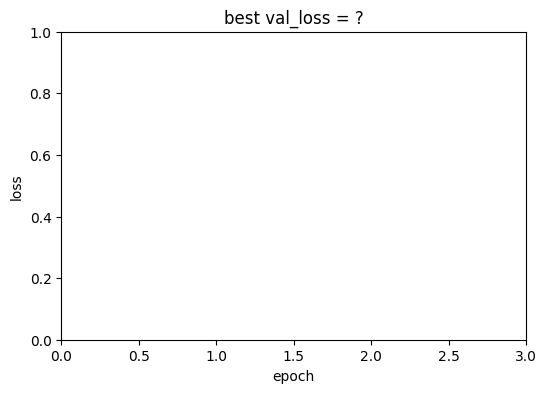

KeyboardInterrupt: 

In [36]:
keras_model.fit(train_data = dl_train,
                val_data = dl_test,
                epochs=3,
                patience=3, #for early stop
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                gradient_accumulation_steps=4
                #mixed_precision='fp16'
               )